In [1]:
import numpy as np
from src.sources.fft import FFTSource

In [2]:
fftsource = FFTSource()
fftsource.start()

In [3]:
import matplotlib.pyplot as plt
_, data = fftsource.read()
plt.plot(data)

In [4]:
data.shape

(137,)

This shows how to use masks to create an image from a 1D array - https://stackoverflow.com/questions/49188161/how-to-slice-numpy-rows-using-start-and-end-index

In [5]:
array = data[:, None] >= np.arange(256)

In [6]:
array.shape

(137, 256)

In [7]:
blank_image = np.ones(shape=(256, data.shape[0]))*255

In [8]:
blank_image[array.T] = 0

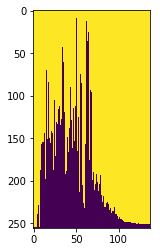

In [9]:
plt.imshow(np.flipud(blank_image))

In [10]:
def convert_to_chart(array, max_value=256):
    """Convert 1D numpy array to a chart image."""
    # Create a "blank", i.e. white with 255, image array
    blank_image = np.ones(shape=(max_value, array.shape[0]))*255
    # Create a 2D mask from the data
    mask = array[:, None] >= np.arange(max_value)
    # Then flip the mask to align with the image and set to 0 (black)
    blank_image[mask.T] = 0
    # We then just need to flip the output again to get back to the original 
    chart_image = np.flipud(blank_image)
    return chart_image

In [11]:
chart = convert_to_chart(data)

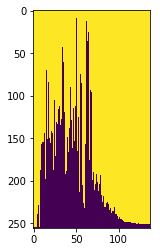

In [12]:
plt.imshow(chart)

In [13]:
from collections import deque
import cv2
import time
import tkinter as tk
from PIL import Image, ImageTk

In [14]:
pil_image = Image.fromarray(chart)

In [15]:
pil_image.size

(137, 256)

In [16]:
resized = pil_image.resize((512, 256))

In [17]:
resized.size

(512, 256)

In [18]:
photo_image = ImageTk.PhotoImage(image=resized)

RuntimeError: Too early to create image

In [19]:
from src.visualisers.camera_gui import display

We can use a canvas instead of a label. https://stackoverflow.com/questions/32376679/tkinter-canvas-doesnt-show-entire-photo-image.

In [40]:
class AudioGUI:
    
    def __init__(self, sensor=None):
        # Setup gui
        self.window = tk.Tk()
        
        # Setup FPS and Quit Button on First Row
        button_frame = tk.Frame(self.window)
        button_frame.pack(expand=True, fill=tk.BOTH)
        # label for fps
        self.fps_label = tk.Label(button_frame)
        self.fps_label.pack(side=tk.LEFT, padx=5, pady=5)
        self.fps_label._frame_times = deque([0]*5)  # arbitrary 5 frame average FPS
        # quit button
        self.quit_button = tk.Button(button_frame, text='Quit', command=lambda: self.quit_())
        self.quit_button.pack(side=tk.RIGHT, padx=5, pady=5)
        
        # Create a canvas
        self.canvas = tk.Canvas(self.window, width=512, height=256)
        self.canvas.pack(expand=True, fill=tk.BOTH)
        
        """
        # Create a list of panels for the GUI
        self.panels = list()
        # label for the original sound frame - index 0
        original_fft = tk.Label(master=self.window)
        original_fft.pack(expand=True, fill=tk.X)
        self.panels.append(original_fft)
        """
        
        # Setup sensor
        if sensor:
            self.add_sensor(sensor)
        
        self.idFrame = None
        
    def add_sensor(self, sensor):
        """Add a sensor to the GUI for display."""
        self.sensor = sensor
        # Start sensor if not already started
        if not self.sensor.started:
            self.sensor.start()
    
    def update(self):
        # Get audio frame
        _, data = self.sensor.read()
        # Convert to image of histogram
        chart_image = convert_to_chart(data)
        # display(chart_image, self.original_fft)
        pil_image = Image.fromarray(chart_image)
        pil_image = pil_image.resize((512, 256))
        photo_image = ImageTk.PhotoImage(image=pil_image)
        if self.idFrame is None:
            self.idFrame = self.canvas.create_image(0, 0, image=photo_image, anchor=tk.NW)
        else:
            self.canvas.itemconfig(self.idFrame, image=photo_image)
            self.canvas.image = photo_image
        self.window.after(10, self.update)
    
    def run(self):
        self.update()
        self.window.mainloop()
        
    def quit_(self):
        self.sensor.stop()
        self.window.destroy()

In [41]:
a_gui = AudioGUI(fftsource)

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


In [42]:
a_gui.run()

In [23]:
_, data = a_gui.sensor.read()

In [24]:
data

array([  0,   0,   0,   6,   0,  21,  41,   0,  36,  56,  39,  98,  25,
       170,  21, 161,  88, 186,  39,  65, 228, 188, 156, 154, 130, 119,
       159, 126, 153, 190, 113, 218, 185,  83,  17, 230, 100,  99,  69,
        72,  56,  61, 230, 177, 203,  73,  58, 106,  14, 125, 183, 211,
       194, 197,   5, 203,  35, 232,  29, 120,  91,   3,  83, 210, 105,
        89,  50, 105,  99,  76,  38,  46,  56,  77, 106, 136,  85,  73,
        62,  46,  36,  43,  29,  26,  26,  22,  24,  52,  19,  14,  14,
        16,  18,  15,  13,  16,  19,  26,  15,  12,  11,  14,  10,   9,
         8,   7,   7,   6,   6,   6,   6,   6,   6,   5,   5,   5,   5,
         5,   5,   5,   5,   5,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4], dtype=uint8)

In [43]:
from src.visualisers.audio_gui import AudioGUI as AG

a_gui_2 = AG(fftsource)

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})
